In [1]:
%load_ext autoreload
%autoreload 2
import torch
import math
import sys
sys.path.append('../..')

import kradagrad as kg
mf = kg.positive_matrix_functions
smf = kg.third_party.shampoo.matrix_functions

norm = lambda x: torch.abs(x).sum()

import matplotlib.pyplot as plt

In [4]:
sz = 1536
log_cond_num = 8
max_eig = 10 ** (log_cond_num/2)

sq = lambda x: -x**4
sqrt = lambda x: -x**(1/4)

nonlin = sq
inv_nonlin = sqrt

nonlin_log_cond_num = inv_nonlin(log_cond_num)

diag = 10 ** nonlin(torch.linspace(0, nonlin_log_cond_num, sz))
Q = torch.linalg.qr(torch.randn(sz, sz, dtype=torch.float64))[0]
Ad = (Q*diag).mm(Q.T).cuda()
Ad = Ad * (max_eig / diag.max()) + 1e-12 * torch.eye(sz, device=Ad.device)
A = Ad.float()
Ab = A.bfloat16()
Ah = A.half()

1e-04 10000.0 100000000.0
-0.001364779 10000.002 -7327195.5


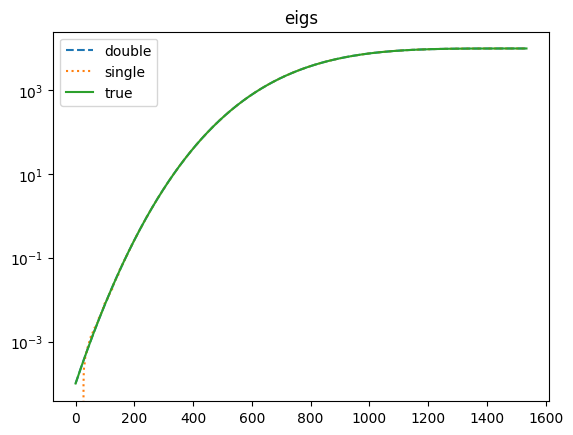

In [5]:
with torch.no_grad():
    Ld = torch.linalg.eigvalsh(Ad).float().cpu().numpy()
    L = torch.linalg.eigvalsh(A).cpu().numpy()
print(Ld.min(), Ld.max(), Ld.max()/Ld.min())
print(L.min(), L.max(), L.max()/L.min())

plt.figure()

plt.semilogy(Ld, '--')
plt.semilogy(L, ':')
plt.semilogy(diag.flipud() * (max_eig / diag.max()))

plt.title('eigs')
plt.legend(['double', 'single', 'true'])

plt.show()

In [6]:
# Invert in double to make sure it's accurate
Aid = Ad.inverse()
Ai = Aid.float()
Aib = Aid.bfloat16()

norm(Ai @ A - torch.eye(sz, device=A.device)) / sz, norm(Aid @ Ad - torch.eye(sz, device=Ad.device)) / sz


(tensor(57.7637, device='cuda:0'),
 tensor(5.6700e-07, device='cuda:0', dtype=torch.float64))

9.912572e-05 10000.0 100881990.0
-0.00033827778 9999.999 -7327193.0


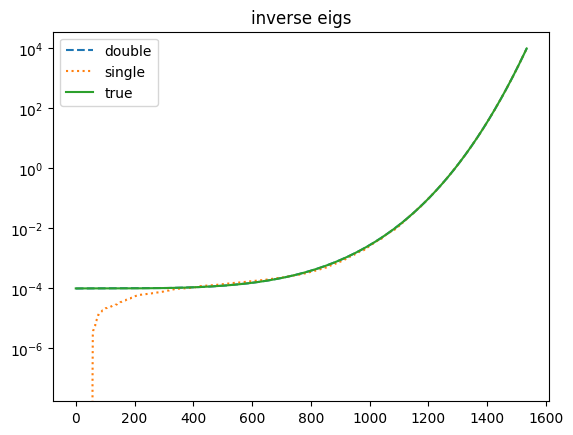

In [7]:
with torch.no_grad():
    Lid = torch.linalg.eigvalsh(Aid).float().cpu().numpy()
    Li = torch.linalg.eigvalsh(Ai).cpu().numpy()
print(Lid.min(), Lid.max(), Lid.max()/Lid.min())
print(Li.min(), Li.max(), Li.max()/L.min())

plt.figure()

plt.semilogy(Lid, '--')
plt.semilogy(Li, ':')
plt.semilogy(diag.max() / diag / max_eig)

plt.title('inverse eigs')
plt.legend(['double', 'single', 'true'])

plt.show()

In [8]:
Aii = mf.matrix_power_svd(Ai, -1, eps=1e-12)
Aiid = mf.matrix_power_svd(Aid, -1, double=True, eps=1e-12)

norm(Aii - Ad) / (sz*max_eig), norm(Aiid - Ad) / (sz*max_eig)

(tensor(5.5405e+08, device='cuda:0', dtype=torch.float64),
 tensor(0.0630, device='cuda:0', dtype=torch.float64))

# sqrts

In [9]:
B1 = mf.matrix_power_svd(A, 0.5)
B1h = mf.matrix_power_svd(A.half(), 0.5)
B1d = mf.matrix_power_svd(Ad, 0.5)

norm(B1h @ B1h.T - Ad) / (sz*max_eig), norm(B1 @ B1.T - Ad) / (sz*max_eig), norm(B1d @ B1d.T - A.double()) / (sz*max_eig), 

(tensor(0.0041, device='cuda:0', dtype=torch.float64),
 tensor(5.6941e-05, device='cuda:0', dtype=torch.float64),
 tensor(5.6619e-05, device='cuda:0', dtype=torch.float64))

In [10]:
B2 = mf.matrix_sqrt_NS(A, iters=25, norm='tr')
B2h = mf.matrix_sqrt_NS(A.half(), iters=25, norm='tr')
B2d = mf.matrix_sqrt_NS(Ad, iters=25, norm='tr', double=True)
norm(B2h @ B2h.T - Ad) / (sz*max_eig), norm(B2 @ B2.T - Ad) / (sz*max_eig), norm(B2d @ B2d.T - Ad) / (sz*max_eig)

(tensor(0.0044, device='cuda:0', dtype=torch.float64),
 tensor(0.0015, device='cuda:0', dtype=torch.float64),
 tensor(2.1710e-06, device='cuda:0', dtype=torch.float64))

## inverse sqrt

In [11]:
# compute -1/2 power of Ai using shampoo libs
B3 = smf.ComputePower(Ai, 2)
B3d = smf.ComputePower(Aid, 2, double=True)
norm(B3 @ B3.T - Ad) / (sz*max_eig), norm(B3d @ B3d.T - Ad) / (sz*max_eig)

(tensor(13.4638, device='cuda:0', dtype=torch.float64),
 tensor(13.4639, device='cuda:0', dtype=torch.float64))

In [12]:
# compute -1/2 and 1/2 power of A using shampoo libs
# compute -1/2 and 1/2 power of A using modified shampoo libs
#B3i = smf.ComputePower(A, 2)
B3i = mf.mat_inv_root(A, 2)
B3id = smf.ComputePower(Ad, 2, double=True)

B3ii = mf.symmetrize(B3i @ A)


print(norm(mf.mat_pow(B3ii, 2) - Ad) / (sz*max_eig), norm(mf.mat_pow(B3id @ Ad, 2) - Ad) / (sz*max_eig))
norm(B3i @ B3i.T - Aid) / (sz*max_eig), norm(B3id @ B3id.T - Aid) / (sz*max_eig)

tensor(0.0118, device='cuda:0', dtype=torch.float64) tensor(5.9220e-11, device='cuda:0', dtype=torch.float64)


(tensor(2.5645, device='cuda:0', dtype=torch.float64),
 tensor(2.5582, device='cuda:0', dtype=torch.float64))

In [13]:
# compute -1/2 power of Ai using eigh
Bii = mf.matrix_power_svd(Ai, -0.5, eps=1e-12)
Biid = mf.matrix_power_svd(Aid, -0.5, double=True, eps=1e-12)
norm(Bii @ Bii.T - Ad) / (sz*max_eig), norm(Biid @ Biid.T - Ad) / (sz*max_eig)

(tensor(13.4646, device='cuda:0', dtype=torch.float64),
 tensor(13.4639, device='cuda:0', dtype=torch.float64))

In [14]:
# compute -1/2 power of A using eigh
Bi = mf.matrix_power_svd(A, -0.5, eps=1e-12)
Bid = mf.matrix_power_svd(Ad, -0.5, double=True, eps=1e-12)
print(norm(Bi @ A @ Bi.T - torch.eye(sz, device=A.device)).cpu() / sz, norm(Bid @ Ad @ Bid.T - torch.eye(sz, device=Ad.device)).cpu() / sz)

norm(Bi @ Bi.T - Aid).cpu() / (sz*max_eig), norm(Bid @ Bid.T - Aid).cpu() / (sz*max_eig)


tensor(2.4125) tensor(2.1480e-09, dtype=torch.float64)


(tensor(2.5591, dtype=torch.float64), tensor(2.5582, dtype=torch.float64))

 # inverse 4th root (as in shampoo)

In [15]:
# compute -1/4 power of Ai using shampoo libs
Bii2 = smf.ComputePower(Ai, 4)
Bii2d = smf.ComputePower(Aid, 4, double=True)
norm(mf.mat_pow(Bii2, 4) - Ad) / (sz*max_eig), norm(mf.mat_pow(Bii2d, 4) - Ad) / (sz*max_eig)

(tensor(13.5182, device='cuda:0', dtype=torch.float64),
 tensor(13.5183, device='cuda:0', dtype=torch.float64))

In [16]:
# compute -1/4 power of Ai using shampoo libs
Bi2 = smf.ComputePower(A, 4)
Bi2d = smf.ComputePower(Ad, 4, double=True)
print(norm(mf.mat_pow(Bi2, 4) @ A - torch.eye(sz, device=A.device)) / sz, norm(mf.mat_pow(Bi2d, 4) @ Ad - torch.eye(sz, device=Ad.device)) / sz)
norm(mf.mat_pow(Bi2, 4) - Aid) / (sz*max_eig), norm(mf.mat_pow(Bi2d, 4) - Aid) / (sz*max_eig)


tensor(5.8415, device='cuda:0') tensor(1.1877e-07, device='cuda:0', dtype=torch.float64)


(tensor(2.5822, device='cuda:0', dtype=torch.float64),
 tensor(2.5818, device='cuda:0', dtype=torch.float64))

In [17]:
# compute -1/4 power of Ai using eigh
Bii3 = mf.matrix_power_svd(Ai, -0.25, eps=1e-12)
Bii3d = mf.matrix_power_svd(Aid, -0.25, double=True, eps=1e-12)
norm(mf.mat_pow(Bii3, 4) - Ad) / (sz*max_eig), norm(mf.mat_pow(Bii3d, 4) - Ad) / (sz*max_eig)

(tensor(13.5185, device='cuda:0', dtype=torch.float64),
 tensor(13.5183, device='cuda:0', dtype=torch.float64))

In [84]:
# compute -1/4 power of A using eigh
Bi3 = mf.matrix_power_svd(Ai, 0.25, eps=1e-12)
Bi3d = mf.matrix_power_svd(Aid, 0.25, double=True, eps=1e-12)
norm(mf.mat_pow(Bi3, 4) - Aid) / (sz*max_eig), norm(mf.mat_pow(Bi3d, 4) - Aid) / (sz*max_eig)


(tensor(1.0035e-05, device='cuda:0', dtype=torch.float64),
 tensor(2.9545e-09, device='cuda:0', dtype=torch.float64))

# 4th roots

In [18]:
B4 = mf.matrix_even_root_N_warm(4, A, iters=20, tol=1e-4, inner_iters=20, inner_tol=1e-6, norm='tr')
B4d = mf.matrix_even_root_N_warm(4, Ad, iters=20, tol=1e-4, inner_iters=20, inner_tol=1e-6, norm='tr', double=True)

norm(mf.mat_pow(B4, 4) - Ad) / (sz*max_eig), norm(mf.mat_pow(B4d, 4) - Ad) / (sz*max_eig)

(tensor(499.7925, device='cuda:0', dtype=torch.float64),
 tensor(nan, device='cuda:0', dtype=torch.float64))

In [65]:
B4i = mf.mat_inv_root(A, 4, iter_count=10)
B4ii = mf.symmetrize(mf.mat_pow(B4i, 3) @ A)

norm(mf.mat_pow(B4ii, 4) - Ad) / (sz*max_eig)

tensor(0.0078, device='cuda:0', dtype=torch.float64)

In [64]:
B5 = mf.matrix_power_svd(A, 0.25)
B5h = mf.matrix_power_svd(A.half(), 0.25)
B5d = mf.matrix_power_svd(Ad, 0.25, double=True)
norm(mf.mat_pow(B5h, 4) - Ad) / (sz*max_eig), norm(mf.mat_pow(B5, 4) - Ad) / (sz*max_eig), norm(mf.mat_pow(B5d, 4) - Ad) / (sz*max_eig)

(tensor(0.0076, device='cuda:0', dtype=torch.float64),
 tensor(0.0002, device='cuda:0', dtype=torch.float64),
 tensor(2.1477e-13, device='cuda:0', dtype=torch.float64))

In [69]:
l_ = min(torch.linalg.eigvalsh(B2).min(), 0)
B6 = mf.mat_root(A, 4, iters=20, norm='tr')
B6h = mf.mat_root(A.half(), 4, iters=20, norm='tr')
B6d = mf.mat_root(Ad, 4, iters=20, norm='tr', double=True)


norm(mf.mat_pow(B6h, 4) - Ad) / (sz*max_eig), norm(mf.mat_pow(B6, 4) - Ad) / (sz*max_eig), norm(mf.mat_pow(B6d, 4) - Ad) / (sz*max_eig)

(tensor(nan, device='cuda:0', dtype=torch.float64),
 tensor(0.0010, device='cuda:0', dtype=torch.float64),
 tensor(0.0001, device='cuda:0', dtype=torch.float64))

# 6th root

In [67]:
B7 = mf.matrix_power_svd(A, 1/6)
B7h = mf.matrix_power_svd(A.half(), 1/6)
B7b = mf.matrix_power_svd(Ab, 1/6)
B7d = mf.matrix_power_svd(Ad, 1/6, double=True)

norm(mf.mat_pow(B7h, 6) - Ad) / (sz*max_eig), norm(mf.mat_pow(B7b, 6) - Ad) / (sz*max_eig), norm(mf.mat_pow(B7, 6) - Ad) / (sz*max_eig), norm(mf.mat_pow(B7d, 6) - Ad) / (sz*max_eig)

(tensor(0.0107, device='cuda:0', dtype=torch.float64),
 tensor(0.0881, device='cuda:0', dtype=torch.float64),
 tensor(0.0002, device='cuda:0', dtype=torch.float64),
 tensor(3.2001e-13, device='cuda:0', dtype=torch.float64))

In [82]:

B7i = mf.mat_inv_root(A, 6, iter_count=10)
B7ii = mf.symmetrize(mf.mat_pow(B7i, 5) @ A)

norm(mf.mat_pow(B7ii, 6) - Ad) / (sz*max_eig), 

(tensor(0.0156, device='cuda:0', dtype=torch.float64),)

In [68]:
B8 = mf.mat_root(A, 6, iters=20, norm='tr')
B8h = mf.mat_root(A.half(), 6, iters=20, norm='tr')
B8d = mf.mat_root(Ad, 6, iters=20, norm='tr', double=True)
norm(mf.mat_pow(B8h, 6) - Ad) / (sz*max_eig), norm(mf.mat_pow(B8, 6) - Ad) / (sz*max_eig), norm(mf.mat_pow(B8d, 6) - Ad) / (sz*max_eig)

(tensor(0.0111, device='cuda:0', dtype=torch.float64),
 tensor(0.0010, device='cuda:0', dtype=torch.float64),
 tensor(4.0830e-13, device='cuda:0', dtype=torch.float64))

In [205]:
B9 = mf.matrix_power_svd(mf.matrix_sqrt_NS(A, iters=20, norm='tr'), 1/3)
B9d = mf.matrix_power_svd(mf.matrix_sqrt_NS(A, iters=20, norm='tr', double=True), 1/3, double=True)
norm(mf.mat_pow(B9, 6) - Ad) / (sz*max_eig), norm(mf.mat_pow(B9d, 6) - Ad) / (sz*max_eig)

(tensor(0.0009, device='cuda:0', dtype=torch.float64),
 tensor(3.2327e-06, device='cuda:0', dtype=torch.float64))

In [215]:
B10 = mf.matrix_even_root_N_warm(6, A, iters=20, tol=1e-4, inner_iters=20, inner_tol=1e-6, norm='tr')
B10d = mf.matrix_even_root_N_warm(6, Ad, iters=20, tol=1e-4, inner_iters=20, inner_tol=1e-6, norm='tr', double=True)

norm(mf.mat_pow(B10, 6) - Ad) / (sz*max_eig), norm(mf.mat_pow(B10d, 6) - Ad) / (sz*max_eig)

(tensor(38975676.1171, device='cuda:0', dtype=torch.float64),
 tensor(1.1638e+08, device='cuda:0', dtype=torch.float64))

# Timing

## 4th roots

In [70]:
%%timeit

torch.cuda.synchronize()
mf.matrix_power_svd(A, 1/4)
torch.cuda.synchronize()

26.2 ms ± 50.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
%%timeit

torch.cuda.synchronize()
mf.matrix_power_svd(Ah, 1/4)
torch.cuda.synchronize()

26.9 ms ± 6.61 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
%%timeit

torch.cuda.synchronize()
B4i = mf.mat_inv_root(A, 4, iter_count=10)
mf.symmetrize(mf.mat_pow(B4i, 3) @ A)
torch.cuda.synchronize()

34.2 ms ± 70.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
%%timeit

torch.cuda.synchronize()
mf.matrix_power_svd(Ab, 1/4)
torch.cuda.synchronize()

26.4 ms ± 4.76 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [74]:
%%timeit

torch.cuda.synchronize()
mf.matrix_power_svd(Ad, 1/4, double=True)
torch.cuda.synchronize()

105 ms ± 16.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [207]:
%%timeit

torch.cuda.synchronize()
mf.mat_root(A, 4, iters=10, tol=1e-6, inner_iters=25, inner_tol=1e-6, norm='tr')
torch.cuda.synchronize()

5.6 ms ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [208]:
%%timeit

torch.cuda.synchronize()
mf.mat_root(Ad, 4, iters=10, tol=1e-6, inner_iters=25, inner_tol=1e-6, norm='tr', double=True)
torch.cuda.synchronize()

5.61 ms ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 6th roots

In [80]:
%%timeit

torch.cuda.synchronize()
mf.matrix_power_svd(A, 1/6)
torch.cuda.synchronize()

26.2 ms ± 9.75 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [76]:
%%timeit

torch.cuda.synchronize()
mf.mat_root(Ad, 6, iters=20, norm='tr', double=True)
torch.cuda.synchronize()

964 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
%%timeit

torch.cuda.synchronize()
mf.matrix_power_svd(A, -1/6, double=True)
torch.cuda.synchronize()

105 ms ± 54.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
%%timeit

torch.cuda.synchronize()
B6i = mf.mat_inv_root(A, 6, iter_count=10)
mf.symmetrize(mf.mat_pow(B6i, 5) @ A)
torch.cuda.synchronize()

37.9 ms ± 40.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
%%timeit

torch.cuda.synchronize()
smf.ComputePower(Ad, 6, double=True)
torch.cuda.synchronize()

1.67 s ± 44.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
